In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## A2/phi vs R - GADGET

In [2]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import barstrength2 as strng

h=0.732
G = 4.299e-6
a0=1
H0 = h*100
omega_lambda=0.716
omega_matter=0.1277/(h**2.)
omega0 = omega_lambda + omega_matter

#path = 'home/ornela/SimCLUES/'
path = '/home/omarioni/'

atime = np.loadtxt(path + 'redshift_outputs.txt')
aexp = atime[:,2]
aexp = aexp[::-1]

vector = ('00','01','03')
vector3 = ('M31','MW','M33')
vector2= ('blue', 'red', 'green')

# snap = h5py.File('/home/ornela/SimCLUES/outputs_1/snap_496.h5py', 'r')
path = '/mnt/is2/alejandro/ornella/'

snap = h5py.File(path + 'outputs_1/snap_496.h5py', 'r')
    
for i in range(0,3):
    cm   = snap['subhalo_0'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_0'+ str('%s' %vector[i])+ '/R200'].value

    pstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Coordinates'].value
    mstr = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Masses'].value
    vel  = snap['subhalo_0'+ str('%s' %vector[i]) + '/Str/Velocities'].value

    z = a0/aexp[0] - 1.
    Ht = H0*np.sqrt(omega_lambda+(1-omega0)*(1+z)**2+omega_matter*(1+z)**3)

#---aca paso las coordenadas respecto al centro de la galaxia------
    xstr = (pstr[:,0]-cm[0])*aexp[0]/h
    ystr = (pstr[:,1]-cm[1])*aexp[0]/h
    zstr = (pstr[:,2]-cm[2])*aexp[0]/h
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)

    v_x = vel[:,0] *np.sqrt(aexp[0]) + Ht *xstr/1000.
    v_y = vel[:,1] *np.sqrt(aexp[0]) + Ht *ystr/1000.
    v_z = vel[:,2] *np.sqrt(aexp[0]) + Ht *zstr/1000.

#----------------------masas----------------------------
    mstr = mstr/h

    r200 = r200*aexp[0]/h

    rgal=0.15*r200

    limit = np.where(r<rgal)
    r_sort = np.sort(r[limit])
    r_indice = np.argsort(r[limit])

    Mc_str = cumsum((mstr[limit])[r_indice])
    M_gal = Mc_str[-1]

#------------------ calculamos M90------------------------------------------
    razon = Mc_str/M_gal
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]
    r50 = r_sort[cincuenta][-1]            

#-------------------------------------------------------------------            
    corte1,=np.where(r<6)
    corte2,=np.where(r<2*r50)
    veloc,=np.where(r<r50)

#----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])

#----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm

    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp[0])

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

  
    A2max, rmax, phimax = strng.a2max(mstr[corte1], xn[corte1], yn[corte1], 20)
    print 'phimax=', phimax, 'A2max=', A2max, 'rbinmax=', rmax
    
    A2, phi, rbin = strng.a2(mstr[corte1], xn[corte1], yn[corte1], 20)

#     print 'phi=', phi, 'A2=', A2, 'rbin=', rbin
    
    phii = phi - phimax

#     data = np.ndarray([np.size(A2),3])
#     data[:,0] = rbin
#     data[:,1] = A2
#     data[:,2] = phii

#     np.savetxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector3[i])+'_A2phivsR.dat', data, fmt=['%12.6f','%12.6f','%12.6f'])
#     np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gd/_data/'+str('%s'%vector3[i])+'_A2phivsR_new.dat', data, fmt=['%12.6f','%12.6f','%12.6f'])


/home/omarioni/miniconda2/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


16868
phimax= 0.8675079941749573 A2max= 0.40782072278781206 rbinmax= 0.5574624538421631
16868
16948
phimax= -1.0020687580108643 A2max= 0.11171409297299521 rbinmax= 0.30058524012565613
16948
8534
phimax= 0.06331627815961838 A2max= 0.06291826244959516 rbinmax= 0.4855991005897522
8534


## A2/phi vs R - GASOLINE

In [3]:
import h5py
import rotation_mio as rot
import barstrength2 as strng

#Parámetros cosmológicos
#--------------------------------------------------------------------------
G = 4.299e-6
a0=1.
#---------------------------------------------------------------------------
vector =(1,2,4)
vector2=('M31','MW','M33')


#path = 'home/ornela/SimCLUES/'
path = '/mnt/sersic2/omarioni/'

snap = h5py.File(path + 'Gasoline/outputs2/snap_1024.h5py', 'r')
    
for i in range(0,3):
    cm   = snap['subhalo_00'+ str('%s' %vector[i])+ '/Center'].value
    r200 = snap['subhalo_00'+ str('%s' %vector[i])+ '/R200'].value
    time = snap['subhalo_00'+ str('%s' %vector[i])+ '/Time'].value
    h    = snap['subhalo_00'+ str('%s' %vector[i])+ '/h'].value
    aexp = snap['subhalo_00'+ str('%s' %vector[i])+ '/aexp'].value

    pstr = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Coordinates'].value
    mstr = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Masses'].value
    vel  = snap['subhalo_00'+ str('%s' %vector[i])+ '/Str/Velocities'].value

#paso las coordenadas al centro de la galaxia
    xstr = (pstr[:,0]-cm[0])
    ystr = (pstr[:,1]-cm[1])
    zstr = (pstr[:,2]-cm[2])
    r    = np.sqrt(xstr**2+ystr**2+zstr**2)
#----------------------------------------------------------------------

    rgal = 0.15*r200          #defino el radio de la galaxia

    limit = np.where(r<rgal)         #hago un límite de los r dentro de rgal
    r_sort = np.sort(r[limit])       #acomodo los r de menor a mayor
    r_indice = np.argsort(r[limit])  #saco los argumentos de r acomodados de menor a mayor

    Mc_str = cumsum(mstr[limit][r_indice])  #masa acumulada en cada radio dentro de rgal
    Mgal = Mc_str[-1]  #masa total de la galaxia

#Calculo de los radios a 50% y 90% la masa de la galaxia
#-----------------------------------------------------------------------
    razon = Mc_str/Mgal 
    noventa, = np.where(razon < 0.9)
    cincuenta, = np.where(razon < 0.5)

    r90 = r_sort[noventa][-1]   #radio a 90% la masa
    r50 = r_sort[cincuenta][-1] #radio a 50% la masa

#-------------------------------------------------------------------------------
#componentes de la velocidad del centro de masa
    veloc, = np.where(r < r50)

    vxcm = sum(mstr[veloc]*vel[:,0][veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*vel[:,1][veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*vel[:,2][veloc])/sum(mstr[veloc])

#velocidades de las estrellas respecto del centro de masa de la galaxia
    vx = vel[:,0] - vxcm
    vy = vel[:,1] - vycm
    vz = vel[:,2] - vzcm


#hago la rotación de las coordenadas respecto del momento angular    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,3*aexp)

    xn = e1x*xstr + e1y*ystr + e1z*zstr
    yn = e2x*xstr + e2y*ystr + e2z*zstr
    zn = e3x*xstr + e3y*ystr + e3z*zstr
    vxn = e1x*vx + e1y*vy + e1z*vz
    vyn = e2x*vx + e2y*vy + e2z*vz
    vzn = e3x*vx + e3y*vy + e3z*vz

    corte3, = np.where(r<6)

    A2, phi, rbin = strng.a2(mstr[corte3], xn[corte3], yn[corte3], 20)
    A2max, rmax, phimax = strng.a2max(mstr[corte3], xn[corte3], yn[corte3], 20)

    print 'phimax=', phimax, 'A2max=', A2max, 'rbinmax=', rmax

    phii = phi - phimax

#     data = np.ndarray([np.size(A2),3])
#     data[:,0] = rbin
#     data[:,1] = A2
#     data[:,2] = phii

#     np.savetxt('/home/ornela/PYTHON/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_A2phivsR.dat', data, fmt=['%12.6f','%12.6f','%12.6f'])
#     np.savetxt('/home/omarioni/Barras_GdGs/Barras_Gs/_data/'+str('%s'%vector2[i])+'_A2phivsR_new.dat', data, fmt=['%12.6f','%12.6f','%12.6f'])


32555
32555
phimax= 0.01082470640540123 A2max= 0.4137941225808446 rbinmax= 0.5429650545120239
26716
26716
phimax= -0.934791624546051 A2max= 0.46238412219889197 rbinmax= 0.48839062452316284
12479
12479
phimax= 0.15623129904270172 A2max= 0.07175497847358894 rbinmax= 0.5115792155265808


#### Gadget M31 lbar

In [3]:
# path = '/home/ornela/PYTHON/'
path = '/home/omarioni/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_A2phivsR.dat')
rn_M31gd  = M31_gd[:,0]
A2_M31gd  = M31_gd[:,1]
phi_M31gd = M31_gd[:,2]

#lbar 1 ----------------------------------------------------------------------
for i in range(1,len(phi_M31gd)-1):
        if ((phi_M31gd[i]<np.arcsin(0.3)) & (phi_M31gd[i]>-np.arcsin(0.3)) & (phi_M31gd[i+1]>np.arcsin(0.3))):
            if ((phi_M31gd[i+2]>np.arcsin(0.3)) | (phi_M31gd[i+2]<-np.arcsin(0.3))):
                pend = (phi_M31gd[i+1]-phi_M31gd[i])/(rn_M31gd[i+1]-rn_M31gd[i])
                ordenada = phi_M31gd[i]- pend*rn_M31gd[i]
                lbar_M31gd = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phi_M31gd[i]>-np.arcsin(0.3)) & (phi_M31gd[i]<np.arcsin(0.3)) & (phi_M31gd[i+1]<-np.arcsin(0.3))):
            if ((phi_M31gd[i+2]>np.arcsin(0.3)) | (phi_M31gd[i+2]<-np.arcsin(0.3))):
                pend = (phi_M31gd[i+1]-phi_M31gd[i])/(rn_M31gd[i+1]-rn_M31gd[i])
                ordenada = phi_M31gd[i]- pend*rn_M31gd[i]
                lbar_M31gd = (-np.arcsin(0.3) - ordenada)/pend
                break
print 'lbar_M31gd=', lbar_M31gd

#lbar 2 ----------------------------------------------------------------------
maxim, = np.where(A2_M31gd == max(A2_M31gd))
mask, = np.where(rn_M31gd >= rn_M31gd[maxim] )
point = A2_M31gd[mask]
radio = rn_M31gd[mask]
hbar  = 0.15
resta = point - hbar

for kk,_ in enumerate(point):
    if resta[kk] < 0:
        break

pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])

lbar_M31gd_2 = (hbar - y0)/ pend
print 'lbar_M31gd_2=', lbar_M31gd_2

lbar_M31gd= 1.9337621476238154
lbar_M31gd_2= 1.3934083242813164


#### Gadget MW lbar

In [4]:
MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_A2phivsR.dat')
rn_MWgd  = MW_gd[:,0]
A2_MWgd  = MW_gd[:,1]
phi_MWgd = MW_gd[:,2]

#lbar 1 ----------------------------------------------------------------------
for i in range(1,len(phi_MWgd)-1):
        if ((phi_MWgd[i]<np.arcsin(0.3)) & (phi_MWgd[i]>-np.arcsin(0.3)) & (phi_MWgd[i+1]>np.arcsin(0.3))):
            if ((phi_MWgd[i+2]>np.arcsin(0.3)) | (phi_MWgd[i+2]<-np.arcsin(0.3))):
                pend = (phi_MWgd[i+1]-phi_MWgd[i])/(rn_MWgd[i+1]-rn_MWgd[i])
                ordenada = phi_MWgd[i]- pend*rn_MWgd[i]
                lbar_MWgd = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phi_MWgd[i]>-np.arcsin(0.3)) & (phi_MWgd[i]<np.arcsin(0.3)) & (phi_MWgd[i+1]<-np.arcsin(0.3))):
            if ((phi_MWgd[i+2]>np.arcsin(0.3)) | (phi_MWgd[i+2]<-np.arcsin(0.3))):
                pend = (phi_MWgd[i+1]-phi_MWgd[i])/(rn_MWgd[i+1]-rn_MWgd[i])
                ordenada = phi_MWgd[i]- pend*rn_MWgd[i]
                lbar_MWgd = (-np.arcsin(0.3) - ordenada)/pend
                break
print 'lbar_MWgd=', lbar_MWgd
                 
#lbar 2 ----------------------------------------------------------------------
maxim, = np.where(A2_MWgd == max(A2_MWgd))
mask, = np.where(rn_M31gd >= rn_MWgd[maxim] )
point = A2_MWgd[mask]
radio = rn_MWgd[mask]
hbar  = 0.15
resta = point - hbar

for kk,_ in enumerate(point):
    if resta[kk] < 0:
        break

pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])

lbar_MWgd_2 = (hbar - y0)/ pend
print 'lbar_MWgd_2=', lbar_MWgd_2

lbar_MWgd= 2.255051220753144
lbar_MWgd_2= -2.1667681207402736


#### Gasoline M31 lbar

In [5]:
M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_A2phivsR.dat')
rn_M31gs  = M31_gs[:,0]
A2_M31gs  = M31_gs[:,1]
phi_M31gs = M31_gs[:,2]

#lbar 1 ----------------------------------------------------------------------
for i in range(1,len(phi_M31gs)-1):
        if ((phi_M31gs[i]<np.arcsin(0.3)) & (phi_M31gs[i]>-np.arcsin(0.3)) & (phi_M31gs[i+1]>np.arcsin(0.3))):
            if ((phi_M31gs[i+2]>np.arcsin(0.3)) | (phi_M31gs[i+2]<-np.arcsin(0.3))):
                pend = (phi_M31gs[i+1]-phi_M31gs[i])/(rn_M31gs[i+1]-rn_M31gs[i])
                ordenada = phi_M31gs[i]- pend*rn_M31gs[i]
                lbar_M31gs = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phi_M31gs[i]>-np.arcsin(0.3)) & (phi_M31gs[i]<np.arcsin(0.3)) & (phi_M31gs[i+1]<-np.arcsin(0.3))):
            if ((phi_M31gs[i+2]>np.arcsin(0.3)) | (phi_M31gs[i+2]<-np.arcsin(0.3))):
                pend = (phi_M31gs[i+1]-phi_M31gs[i])/(rn_M31gs[i+1]-rn_M31gs[i])
                ordenada = phi_M31gs[i]- pend*rn_M31gs[i]
                lbar_M31gs = (-np.arcsin(0.3) - ordenada)/pend
                break
print 'lbar_M31gs=', lbar_M31gs
                 
#lbar 2 ----------------------------------------------------------------------
maxim, = np.where(A2_M31gs == max(A2_M31gs))
mask, = np.where(rn_M31gs >= rn_M31gs[maxim] )
point = A2_M31gs[mask]
radio = rn_M31gs[mask]
hbar  = 0.15
resta = point - hbar

for kk,_ in enumerate(point):
    if resta[kk] < 0:
        break

pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])
                 
lbar_M31gs_2 = (hbar - y0)/ pend
print 'lbar_M31gs_2=', lbar_M31gs_2

lbar_M31gs= 1.3608429004639995
lbar_M31gs_2= 0.8378693451092031


#### Gasoline MW lbar

In [6]:
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_A2phivsR.dat')
rn_MWgs  = MW_gs[:,0]
A2_MWgs  = MW_gs[:,1]
phi_MWgs = MW_gs[:,2]
                 
#lbar 1 ----------------------------------------------------------------------
for i in range(1,len(phi_MWgs)-1):
        if ((phi_MWgs[i]<np.arcsin(0.3)) & (phi_MWgs[i]>-np.arcsin(0.3)) & (phi_MWgs[i+1]>np.arcsin(0.3))):
            if ((phi_MWgs[i+2]>np.arcsin(0.3)) | (phi_MWgs[i+2]<-np.arcsin(0.3))):
                pend = (phi_MWgs[i+1]-phi_MWgs[i])/(rn_MWgs[i+1]-rn_MWgs[i])
                ordenada = phi_MWgs[i]- pend*rn_MWgs[i]
                lbar_MWgs = (np.arcsin(0.3) - ordenada)/pend
                break
        elif ((phi_MWgs[i]>-np.arcsin(0.3)) & (phi_MWgs[i]<np.arcsin(0.3)) & (phi_MWgs[i+1]<-np.arcsin(0.3))):
            if ((phi_MWgs[i+2]>np.arcsin(0.3)) | (phi_MWgs[i+2]<-np.arcsin(0.3))):
                pend = (phi_MWgs[i+1]-phi_MWgs[i])/(rn_MWgs[i+1]-rn_MWgs[i])
                ordenada = phi_MWgs[i]- pend*rn_MWgs[i]
                lbar_MWgs = (-np.arcsin(0.3) - ordenada)/pend
                break
print 'lbar_MWgs=', lbar_MWgs
                 
#lbar 2 ----------------------------------------------------------------------
maxim, = np.where(A2_MWgs == max(A2_MWgs))
mask, = np.where(rn_MWgs >= rn_MWgs[maxim] )
point = A2_MWgs[mask]
radio = rn_MWgs[mask]
hbar  = 0.15
resta = point - hbar


for kk,_ in enumerate(point):
    if resta[kk] < 0:
        break

pend = (point[kk] - point[kk-1]) / (radio[kk] - radio[kk-1])
y0 = (point[kk-1]*radio[kk] - point[kk]*radio[kk-1]) / (radio[kk] - radio[kk-1])

lbar_MWgs_2 = (hbar - y0)/ pend
print 'lbar_MWgs_2=', lbar_MWgs_2

lbar_MWgs= 3.1056563543927282
lbar_MWgs_2= 1.2974329927085249


In [6]:
data = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/density_profiles.dat')
bin_M31gd     = data[:,0]
bin_MWgd      = data[:,1]
bin_M31gs     = data[:,2]
bin_MWgs      = data[:,3]
density_M31gd = data[:,4]
density_M31gs = data[:,5]
density_MWgd  = data[:,6]
density_MWgs  = data[:,7]

In [7]:
path = '/home/omarioni/'
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_A2phivsR_new.dat')
rn_M31gd  = M31_gd[:,0]
A2_M31gd  = M31_gd[:,1]
# phi_M31gd = M31_gd[:,2]

MW_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/MW_A2phivsR_new.dat')
rn_MWgd  = MW_gd[:,0]
A2_MWgd  = MW_gd[:,1]
# phi_MWgd = MW_gd[:,2]

M33_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M33_A2phivsR_new.dat')
rn_M33gd  = M33_gd[:,0]
A2_M33gd  = M33_gd[:,1]
# phi_M33gd = M33_gd[:,2]


M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_A2phivsR_new.dat')
rn_M31gs  = M31_gs[:,0]
A2_M31gs  = M31_gs[:,1]
# phi_M31gd = M31_gd[:,2]

MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_A2phivsR_new.dat')
rn_MWgs  = MW_gs[:,0]
A2_MWgs  = MW_gs[:,1]
# phi_MWgd = MW_gd[:,2]

M33_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M33_A2phivsR_new.dat')
rn_M33gs  = M33_gs[:,0]
A2_M33gs  = M33_gs[:,1]
# phi_M33gd = M33_gd[:,2]


In [8]:
M31_gd = np.loadtxt(path + 'Barras_GdGs/Barras_Gd/_data/M31_lbarvstime2.dat')
lbar_M31gd = M31_gd[0,1]

#------------------------------------------------------------------------------------------
M31_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/M31_lbarvstime.dat')
lbar_M31gs = M31_gs[0,1]

#------------------------------------------------------------------------------------------
MW_gs = np.loadtxt(path + 'Barras_GdGs/Barras_Gs/_data/MW_lbarvstime.dat')
lbar_MWgs = MW_gs[0,1]

In [9]:
print lbar_M31gd
print lbar_M31gs
print lbar_MWgs

1.393432
0.837873
1.297434


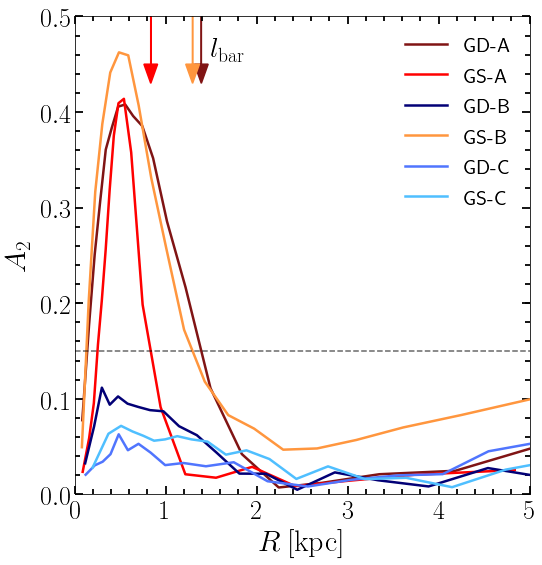

In [17]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

# fig=plt.figure(1,figsize=(16,16))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.12, left =0.16, right = 0.95, top = 0.95)


ax.plot(rn_M31gd,A2_M31gd,'-', lw=2.5, color='#801414', label='GD-A')
ax.plot(rn_M31gs,A2_M31gs,'-', lw=2.5, color='#FF0000', label='GS-A')
ax.plot(rn_MWgd, A2_MWgd, '-', lw=2.5, color='#020076', label='GD-B')
ax.plot(rn_MWgs ,A2_MWgs, '-', lw=2.5, color='#FF963E', label='GS-B')
ax.plot(rn_M33gd,A2_M33gd,'-', lw=2.5, color='#5075FE', label='GD-C')
ax.plot(rn_M33gs,A2_M33gs,'-', lw=2.5, color='#4FBFFF', label='GS-C')

ax.set_ylabel(r'$A_{\mathrm{2}}$', fontsize=30)
ax.set_xlabel(r'$R\:\mathrm{[kpc]}$', fontsize=30)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5])
ax.set_xticks([0,1,2,3,4,5])
ax.set_ylim(0,0.5)
ax.set_xlim(0,5)

ax.minorticks_on()
ax.tick_params( labelsize=26)
ax.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')

ax.arrow(x=lbar_M31gd,y=0.5,dx=0,dy=-0.07,color='#801414', lw=1.5,
         head_length=0.02,head_width=0.15,length_includes_head=True)
ax.arrow(x=lbar_M31gs,y=0.5,dx=0,dy=-0.07,color='#FF0000', lw=1.5,
         head_length=0.02,head_width=0.15,length_includes_head=True)
ax.arrow(x=lbar_MWgs,y=0.5,dx=0,dy=-0.07,color='#FF963E', lw=1.5,
         head_length=0.02,head_width=0.15,length_includes_head=True)
ax.text(1.5,0.46,'$l_{\mathrm{bar}}$',fontsize=28,color='k',ha='left',va='center')
ax.axhline(y=0.15,ls='--',lw=1.5,color='k', alpha=0.6)
ax.legend(fontsize=21,frameon=False, loc=1)

fig.savefig('/home/omarioni/Barras_GdGs/Barras_Gd/_imagenes/A2_phi_vsR_new.pdf', dpi = 100, xxbox_inches='tight')
# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2_phi_vsR.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

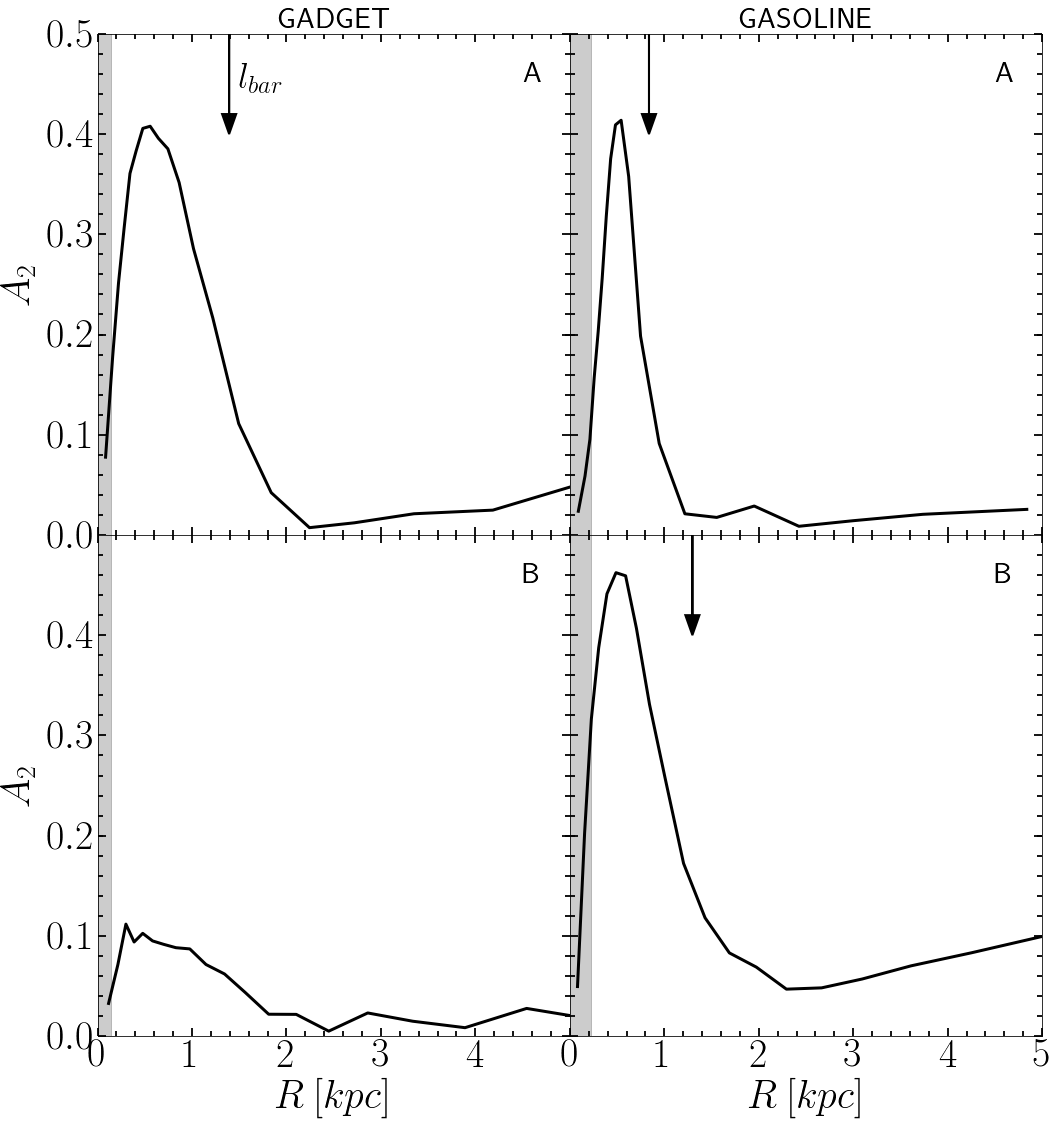

In [13]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

# fig=plt.figure(1,figsize=(16,16))
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
#                        gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.1, right = 0.92, top = 0.95, wspace=0., hspace= 0)



# ax1=fig.add_subplot(221)

ax[0,0].plot(rn_M31gd ,A2_M31gd,'-', lw=3, color='k')
# ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel(r'$A_{2}$', fontsize=40)
ax[0,0].set_yticks([0.0,0.1,0.2,0.3,0.4,0.5])
# ax[0,0].set_yticklabels([0.0,0.1,0.2,0.3,0.4,0.5])
ax[0,0].set_xticks([0,1,2,3,4])
ax[0,0].set_xticklabels([])
ax[0,0].set_ylim(0,0.5)
ax[0,0].set_xlim(0,5)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,0].axvline(x=lbar_M31gd, color='b', lw=2, ls=':')
ax[0,0].text(4.7, 0.46, 'A', fontsize=30, color='black', ha='right', va='center')
# lbar1_met = ax[0,0].arrow( lbar_M31gd, 0.1, 0.0, -0.08,fc='r', ec='r',lw=2,head_width=0.15, head_length=0.02 )
ax[0,0].arrow( lbar_M31gd_2, 0.5, 0.0, -0.08, fc='k', ec='k',lw=2,head_width=0.15, head_length=0.02 )
# ax[0,0].legend([lbar1_met, lbar2_met],[r'$l_{bar}$ method 1', r'$l_{bar}$ method 2'],fontsize=25, frameon=True, loc=2)
ax[0,0].text(1.5,0.45,r'$l_{bar}$', fontsize=35, ha='left', va='center',color='k')
ax[0,0].set_title('GADGET', loc='center', fontsize=30)
ax[0,0].fill_betweenx([-1,0.6],0,0.14, color='k', alpha=0.2)

# ax00 = ax[0,0].twinx()
# ax00.plot(bin_M31gd,np.log10(density_M31gd),'--', lw=3, color='k')
# # ax00.axvline(x=lbar_M31gd, color='b', lw=2, ls=':')
# # ax00.set_ylabel(r'$log(\Sigma \: [M_{\odot} \: kpc^{-2}])$', fontsize=40)#, color='b')
# # ax00.set_xlabel(r'$R\:[kpc]$', fontsize=40)
# ax00.set_xticklabels([])
# ax00.set_yticks([7,8,9,10])
# ax00.set_yticklabels([])
# ax00.set_ylim(7,10)
# ax00.set_xlim(0,5)
# ax00.minorticks_on()
# # ax00.spines['right'].set_color('b')
# ax00.tick_params( labelsize=40)#, color='b')
# ax00.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on', color='k')
# ax00.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on', color='k')



#------------------------------------------------------

# ax2=fig.add_subplot(222)
ax[0,1].plot(rn_M31gs,A2_M31gs,'-', lw=3, color='k')
# ax[0,1].set_xticklabels([])
ax[0,1].set_yticks([0.0,0.1,0.2,0.3,0.4,0.5])
ax[0,1].set_xticks([0,1,2,3,4,5])
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
# ax[0,1].set_ylabel(r'$A_{2}$', fontsize=40)
ax[0,1].set_ylim(0,0.5)
ax[0,1].set_xlim(0,5)
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[0,1].axvline(x=lbar_M31gs, color='b', lw=2, ls=':')
ax[0,1].text(4.7, 0.46, 'A', fontsize=30, color='black', ha='right', va='center')
# ax[0,1].arrow( lbar_M31gs, 0.1, 0.0, -0.08,fc='r', ec='r',lw=2,head_width=0.15, head_length=0.02 )
ax[0,1].arrow( lbar_M31gs_2, 0.5, 0.0, -0.08,fc='k', ec='k',lw=2,head_width=0.15, head_length=0.02 )
ax[0,1].set_title('GASOLINE', loc='center', fontsize=30)
ax[0,1].fill_betweenx([-1,0.6],0,0.22, color='k', alpha=0.2)


# ax01 = ax[0,1].twinx()
# ax01.plot(bin_M31gs,np.log10(density_M31gs),'--', lw=3, color='k')
# # ax01.axvline(x=lbar_M31gs, color='b', lw=2, ls=':')
# ax01.set_ylabel(r'$log(\Sigma \: [M_{\odot} \: kpc^{-2}])$', fontsize=40)#, color='b')
# # ax01.set_xlabel(r'$R\:[kpc]$', fontsize=40)
# ax01.set_xticks([0,1,2,3,4,5])
# ax01.set_xticklabels([])
# ax01.set_yticks([8,9,10])
# ax01.set_ylim(7,10)
# ax01.set_xlim(0,5)
# ax01.minorticks_on()
# # ax01.spines['right'].set_color('b')
# ax01.tick_params( labelsize=40)#, color='b')
# ax01.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on', color='k')
# ax01.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on', color='k')
# # ax01.fill_between([-1,6],np.arcsin(0.3),-np.arcsin(0.3), color='k', alpha=0.2)

# #---------------------------------------------------------

# ax3=fig.add_subplot(223)
ax[1,0].plot(rn_MWgd ,A2_MWgd,'-', lw=3, color='k')
ax[1,0].set_xticks([0,1,2,3,4])
ax[1,0].set_yticks([0.0,0.1,0.2,0.3,0.4])
ax[1,0].set_ylabel(r'$A_{2}$', fontsize=40)
ax[1,0].set_xlabel(r'$R\:[kpc]$', fontsize=40)
ax[1,0].set_ylim(0,0.5)
ax[1,0].set_xlim(0,5)
ax[1,0].minorticks_on()
ax[1,0].tick_params( labelsize=40)
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[2,0].axvline(x=lbar_MWgd, color='r', lw=2, ls='--')
ax[1,0].text(4.7, 0.46, 'B', fontsize=30, color='black', ha='right', va='center')
# ax[1,0].arrow( lbar_MWgd, 0.1, 0.0, -0.08,fc='r', ec='r',lw=2,head_width=0.15, head_length=0.02 )
# ax[1,0].arrow( lbar_MWgd_2, 0.1, 0.0, -0.08,fc='b', ec='b',lw=2,head_width=0.15, head_length=0.02 )
ax[1,0].fill_betweenx([-1,0.6],0,0.14, color='k', alpha=0.2)

# ax10 = ax[1,0].twinx()
# # ax10.plot(rn_MWgd,phi_MWgd,':', lw=3, color='k')
# ax10.plot(bin_MWgd,np.log10(density_MWgd),'--', lw=3, color='k')
# # ax20.axvline(x=lbar_MWgd, color='r', lw=2, ls='--')
# # ax10.set_ylabel(r'$log(\Sigma \: [M_{\odot} \: kpc^{-2}])$', fontsize=40)
# # ax10.set_xlabel(r'$R\:[kpc]$', fontsize=40)#, color='b')
# ax10.set_xticks([0,1,2,3,4])
# # ax10.set_xticklabels([])
# ax10.set_yticks([7,8,9,10])
# ax10.set_yticklabels([])
# ax10.set_ylim(7,10)
# ax10.set_xlim(0,5)
# ax10.minorticks_on()
# # ax01.spines['right'].set_color('b')
# ax10.tick_params( labelsize=40)#, color='b')
# ax10.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on', color='k')
# ax10.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on', color='k')
# # ax10.fill_between([-1,6],np.arcsin(0.3),-np.arcsin(0.3), color='k', alpha=0.2)


# # #---------------------------------------------------------------------------------------
# # ax4=fig.add_subplot(224)
ax[1,1].plot(rn_MWgs ,A2_MWgs,'-', lw=3, color='k')
# ax[2,1].set_xticklabels([])
ax[1,1].set_yticks([0.0,0.1,0.2,0.3,0.4])
ax[1,1].set_yticklabels([])
ax[1,1].set_xticks([0,1,2,3,4,5])
ax[1,1].set_xlabel(r'$R\:[kpc]$', fontsize=40)
ax[1,1].set_ylim(0,0.5)
ax[1,1].set_xlim(0,5)
ax[1,1].minorticks_on()
ax[1,1].tick_params( labelsize=40)
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
# ax[2,1].axvline(x=lbar_MWgs, color='r', lw=2, ls='--')
ax[1,1].text(4.7, 0.46, 'B', fontsize=30, color='black', ha='right', va='center')
# ax[1,1].arrow( lbar_MWgs, 0.1, 0.0, -0.08,fc='r', ec='r',lw=2,head_width=0.15, head_length=0.02 )
ax[1,1].arrow( lbar_MWgs_2, 0.5, 0.0, -0.08,fc='k', ec='k',lw=2,head_width=0.15, head_length=0.02 )
ax[1,1].fill_betweenx([-1,0.6],0,0.22, color='k', alpha=0.2)

# ax11 = ax[1,1].twinx()
# ax11.plot(bin_MWgs,np.log10(density_MWgs),'--', lw=3, color='k')
# ax11.set_ylabel(r'$log(\Sigma \: [M_{\odot} \: kpc^{-2}])$', fontsize=40)#, color='b')
# # ax01.set_xlabel(r'$R\:[kpc]$', fontsize=40)
# ax11.set_xticks([0,1,2,3,4,5])
# # ax01.set_xticklabels([])
# ax11.set_yticks([7,8,9,10])
# ax11.set_ylim(7,10)
# ax11.set_xlim(0,5)
# ax11.minorticks_on()
# # ax01.spines['right'].set_color('b')
# ax11.tick_params( labelsize=40)#, color='b')
# ax11.tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on', color='k')
# ax11.tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on', color='k')


fig.savefig('/home/omarioni/A2_phi_vsR.png', dpi = 100, xxbox_inches='tight')
# fig.savefig('/home/ornela/overleaf/13216980csjxswjndpmj/A2_phi_vsR.pdf', dpi = 100, xxbox_inches='tight')

plt.show()

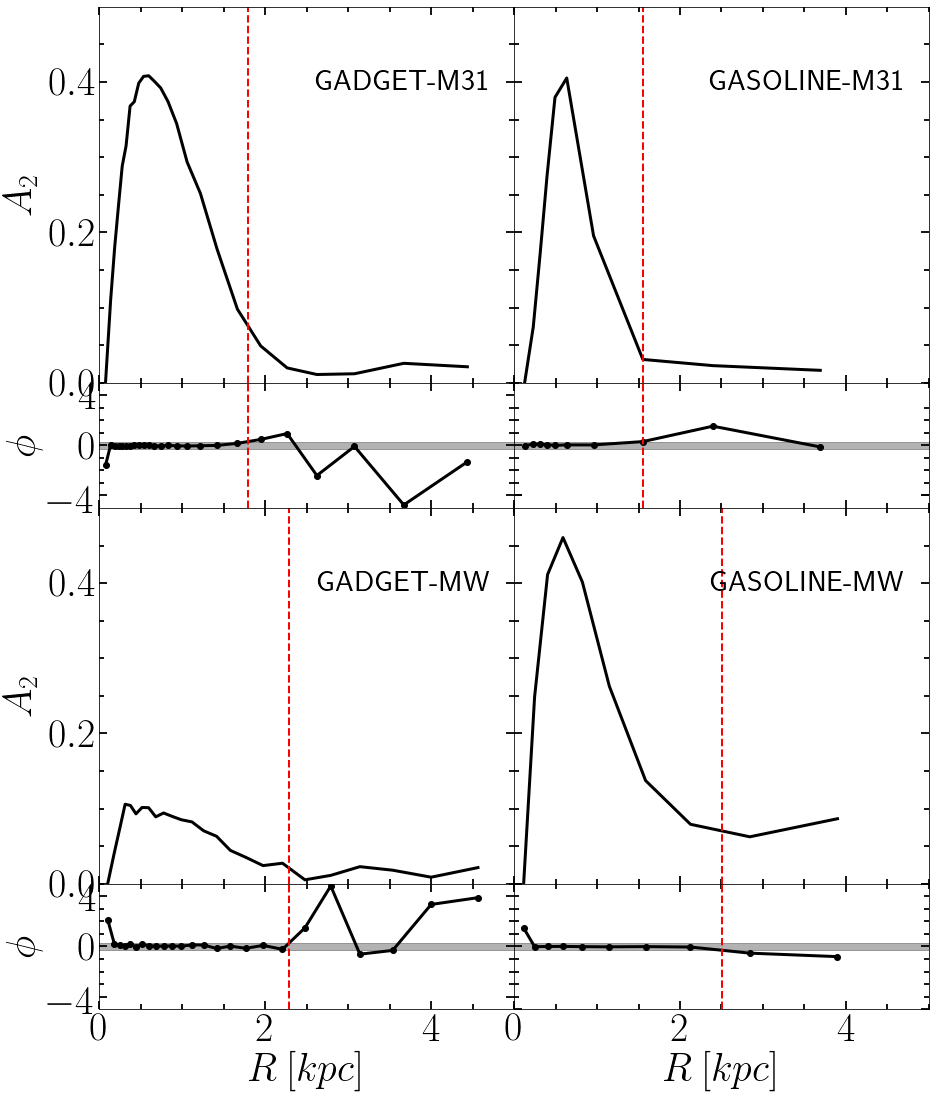

In [88]:
from __future__ import unicode_literals

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

# fig=plt.figure(1,figsize=(16,16))
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 16), sharex=True,
                       gridspec_kw = {'height_ratios':[3,1,3,1]})
fig.subplots_adjust(bottom=0.08, left =0.2, right = 0.92, top = 0.95, wspace=0., hspace= 0)



# ax1=fig.add_subplot(221)

ax[0,0].plot(rn_M31gd ,A2_M31gd,'-', lw=3, color='k')
# ax[0,0].set_xticklabels([])
ax[0,0].set_ylabel(r'$A_{2}$', fontsize=40)
ax[0,0].set_ylim(0,0.5)
ax[0,0].set_xlim(0,5)
ax[0,0].minorticks_on()
ax[0,0].tick_params( labelsize=40)
ax[0,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax[0,0].axvline(x=lbar_M31gd, color='r', lw=2, ls='--')
ax[0,0].text(4.7, 0.4, 'GADGET-M31', fontsize=30, color='black', ha='right', va='center')

# ax01 = ax1.twinx()
ax[1,0].plot(rn_M31gd,phi_M31gd,'o-', lw=3, color='k')
ax[1,0].axvline(x=lbar_M31gd, color='r', lw=2, ls='--')
ax[1,0].set_ylabel(r'$\phi$', fontsize=40)#, color='b')
# ax[1,0].set_xticklabels([])
ax[1,0].set_yticks([-4,0,4])
ax[1,0].set_ylim(-5,5)
ax[1,0].set_xlim(0,5)
ax[1,0].minorticks_on()
# ax01.spines['right'].set_color('b')
ax[1,0].tick_params( labelsize=40)#, color='b')
ax[1,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on', color='k')
ax[1,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on', color='k')
ax[1,0].fill_between([-1,6],np.arcsin(0.3),-np.arcsin(0.3), color='k', alpha=0.3)




#------------------------------------------------------

# ax2=fig.add_subplot(222)
ax[0,1].plot(rn_M31gs,A2_M31gs,'-', lw=3, color='k')
# ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
# ax[0,1].set_ylabel(r'$A_{2}$', fontsize=40)
ax[0,1].set_ylim(0,0.5)
ax[0,1].set_xlim(0,5)
ax[0,1].minorticks_on()
ax[0,1].tick_params( labelsize=40)
ax[0,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[0,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax[0,1].axvline(x=lbar_M31gs, color='r', lw=2, ls='--')
ax[0,1].text(4.7, 0.4, 'GASOLINE-M31', fontsize=30, color='black', ha='right', va='center')

# ax01 = ax1.twinx()
ax[1,1].plot(rn_M31gs,phi_M31gs,'o-', lw=3, color='k')
ax[1,1].axvline(x=lbar_M31gs, color='r', lw=2, ls='--')
# ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
# ax[1,1].set_ylabel(r'$\phi$', fontsize=40)#, color='b')
ax[1,1].set_yticks([-4,0,-4])
ax[1,1].set_ylim(-5,5)
ax[1,1].set_xlim(0,5)
ax[1,1].minorticks_on()
# ax01.spines['right'].set_color('b')
ax[1,1].tick_params( labelsize=40)#, color='b')
ax[1,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on', color='k')
ax[1,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on', color='k')
ax[1,1].fill_between([-1,6],np.arcsin(0.3),-np.arcsin(0.3), color='k', alpha=0.3)

# #---------------------------------------------------------

# ax3=fig.add_subplot(223)
ax[2,0].plot(rn_MWgd ,A2_MWgd,'-', lw=3, color='k')
# ax[2,0].set_xticklabels([])
ax[2,0].set_ylabel(r'$A_{2}$', fontsize=40)
ax[2,0].set_ylim(0,0.5)
ax[2,0].set_xlim(0,5)
ax[2,0].minorticks_on()
ax[2,0].tick_params( labelsize=40)
ax[2,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[2,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax[2,0].axvline(x=lbar_MWgd, color='r', lw=2, ls='--')
ax[2,0].text(4.7, 0.4, 'GADGET-MW', fontsize=30, color='black', ha='right', va='center')

# ax01 = ax1.twinx()
ax[3,0].plot(rn_MWgd,phi_MWgd,'o-', lw=3, color='k')
ax[3,0].axvline(x=lbar_MWgd, color='r', lw=2, ls='--')
ax[3,0].set_ylabel(r'$\phi$', fontsize=40)
ax[3,0].set_xlabel(r'$R\:[kpc]$', fontsize=40)#, color='b')
ax[3,0].set_yticks([-4,0,4])
ax[3,0].set_ylim(-5,5)
ax[3,0].set_xlim(0,5)
ax[3,0].minorticks_on()
# ax01.spines['right'].set_color('b')
ax[3,0].tick_params( labelsize=40)#, color='b')
ax[3,0].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on', color='k')
ax[3,0].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on', color='k')
ax[3,0].fill_between([-1,6],np.arcsin(0.3),-np.arcsin(0.3), color='k', alpha=0.3)


# #---------------------------------------------------------------------------------------
# ax4=fig.add_subplot(224)
ax[2,1].plot(rn_MWgs ,A2_MWgs,'-', lw=3, color='k')
# ax[2,1].set_xticklabels([])
ax[2,1].set_yticklabels([])
ax[2,1].set_ylim(0,0.5)
ax[2,1].set_xlim(0,5)
ax[2,1].minorticks_on()
ax[2,1].tick_params( labelsize=40)
ax[2,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on')
ax[2,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on')
ax[2,1].axvline(x=lbar_MWgs, color='r', lw=2, ls='--')
ax[2,1].text(4.7, 0.4, 'GASOLINE-MW', fontsize=30, color='black', ha='right', va='center')

# ax01 = ax1.twinx()
ax[3,1].plot(rn_MWgs,phi_MWgs,'o-', lw=3, color='k')
ax[3,1].axvline(x=lbar_MWgs, color='r', lw=2, ls='--')
ax[3,1].set_xlabel(r'$R\:[kpc]$', fontsize=40)#, color='b')
ax[3,1].set_yticklabels([])
ax[3,1].set_ylim(-5,5)
ax[3,1].set_xlim(0,5)
ax[3,1].minorticks_on()
# ax01.spines['right'].set_color('b')
ax[3,1].tick_params( labelsize=40)#, color='b')
ax[3,1].tick_params('both', length=5, width=1.8,which='minor', direction='in', right='on',top='on', color='k')
ax[3,1].tick_params('both', length=8, width=1.8,which='major', direction='in', right='on',top='on', color='k')
ax[3,1].fill_between([-1,6],np.arcsin(0.3),-np.arcsin(0.3), color='k', alpha=0.3)

fig.savefig('/home/ornela/Dropbox/Presentacion_graficos/A2_phi_vsR.png', dpi = 100, xxbox_inches='tight')
# #fig.savefig('/home/ornela/Escritorio/mi_tesis/Figures/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
# #fig.savefig('/home/ornela/Escritorio/presentacion_final/GD_'+str('%s'%vector4[i])+'-Vc.png', dpi = 100)
plt.show()


In [7]:
?np.pi

Type:        float
String form: 3.14159265359
Docstring:  
float(x) -> floating point number

Convert a string or number to a floating point number, if possible.


In [9]:
?plt.arrow

Signature: plt.arrow(x, y, dx, dy, hold=None, **kwargs)
Docstring:
Add an arrow to the axes.

Draws arrow on specified axis from (`x`, `y`) to (`x` + `dx`,
`y` + `dy`). Uses FancyArrow patch to construct the arrow.

Parameters
----------
x : float
    X-coordinate of the arrow base
y : float
    Y-coordinate of the arrow base
dx : float
    Length of arrow along x-coordinate
dy : float
    Length of arrow along y-coordinate

Returns
-------
a : FancyArrow
    patches.FancyArrow object

Other Parameters
-----------------
Optional kwargs (inherited from FancyArrow patch) control the arrow
construction and properties:

Constructor arguments
  *width*: float (default: 0.001)
    width of full arrow tail

  *length_includes_head*: [True | False] (default: False)
    True if head is to be counted in calculating the length.

  *head_width*: float or None (default: 3*width)
    total width of the full arrow head

  *head_length*: float or None (default: 1.5 * head_width)
    length of arrow he